In [378]:
import numpy as np
import random
import statistics as stat
import matplotlib.pyplot as plt
import scipy
import networkx as nx
import collections
import itertools
import pickle
import time
import pandas as pd
pd.options.mode.chained_assignment = None

n = int(1e6)
init = 100
i0 = init / n
mu = 5
delta_no_dispersion = 0
delta_low_dispersion = .4
delta_high_dispersion = 2
nu_no_dispersion = mu + delta_no_dispersion * mu**2
nu_low_dispersion = mu + delta_low_dispersion * mu**2
nu_high_dispersion = mu + delta_high_dispersion * mu**2
R0 = 3
gamma = 1

dx = .1
x_max = 20
xs = np.array([dx/2 * i for i in range(1, 2*round(x_max/dx), 2)])
ts_ode = np.linspace(0, x_max, 1001)
reps = 200

In [530]:
### save and load simulation and ODE results

### load    

# sims_no_dispersion = pd.read_pickle('data/sims_no_dispersion.pkl')
# sims_low_dispersion = pd.read_pickle('data/sims_low_dispersion.pkl')
# sims_high_dispersion = pd.read_pickle('data/sims_high_dispersion.pkl')

# with open('data/odes_no_dispersion.pkl', 'rb') as f:
#     odes_no_dispersion = pickle.load(f)
# with open('data/odes_low_dispersion.pkl', 'rb') as f:
#     odes_low_dispersion = pickle.load(f)
# with open('data/odes_high_dispersion.pkl', 'rb') as f:
#     odes_high_dispersion = pickle.load(f)

### save

# sims_no_dispersion.to_pickle('data/sims_no_dispersion.pkl')
# sims_low_dispersion.to_pickle('data/sims_low_dispersion.pkl')
# sims_high_dispersion.to_pickle('data/sims_high_dispersion.pkl')

# with open('data/odes_no_dispersion.pkl', 'wb') as f:
#     pickle.dump(odes_no_dispersion, f)
# with open('data/odes_low_dispersion.pkl', 'wb') as f:
#     pickle.dump(odes_low_dispersion, f)
# with open('data/odes_high_dispersion.pkl', 'wb') as f:
#     pickle.dump(odes_high_dispersion, f)

In [3]:
### initialize Poisson network with no dispersion

G_no_dispersion = nx.fast_gnp_random_graph(n, mu/(n-1))



### initialize negative binomial network with low dispersion

nu = nu_low_dispersion
while True:
    degs = np.random.negative_binomial(mu**2/(nu-mu), mu/nu, n)
    if sum(degs) % 2 == 0:
        break

G_low_dispersion_multi = nx.configuration_model(degs)
G_low_dispersion = nx.empty_graph(n)
G_low_dispersion.add_edges_from([(a,b) for a,b in G_low_dispersion_multi.edges() if a != b])



### initialize negative binomial network with high dispersion

nu = nu_high_dispersion
while True:
    degs = np.random.negative_binomial(mu**2/(nu-mu), mu/nu, n)
    if sum(degs) % 2 == 0:
        break

G_high_dispersion_multi = nx.configuration_model(degs)
G_high_dispersion = nx.empty_graph(n)
G_high_dispersion.add_edges_from([(a,b) for a,b in G_high_dispersion_multi.edges() if a != b])

In [360]:
### general functions

class _ListDict_(object):
    def __init__(self, weighted = False):
        self.item_to_position = {}
        self.items = []

        self.weighted = weighted
        if self.weighted:
            self.weight = collections.defaultdict(int) #presume all weights positive
            self.max_weight = 0
            self._total_weight = 0
            self.max_weight_count = 0
            

    def __len__(self):
        return len(self.items)

    def __contains__(self, item):
        return item in self.item_to_position

    def _update_max_weight(self):
        C = Counter(self.weight.values())  #may be a faster way to do this, we only need to count the max.
        self.max_weight = max(C.keys())
        self.max_weight_count = C[self.max_weight]

        
    def insert(self, item, weight = None):
        if self.__contains__(item):
            self.remove(item)
        if weight != 0:
            self.update(item, weight_increment=weight)
        

    def update(self, item, weight_increment = None):
        if weight_increment is not None: #will break if passing a weight to unweighted case
            if weight_increment > 0 or self.weight[item] != self.max_weight:
                self.weight[item] = self.weight[item] + weight_increment
                self._total_weight += weight_increment
                if self.weight[item] > self.max_weight:
                    self.max_weight_count = 1
                    self.max_weight = self.weight[item]
                elif self.weight[item] == self.max_weight:
                    self.max_weight_count += 1
            else: #it's a negative increment and was at max
                self.max_weight_count -= 1
                self.weight[item] = self.weight[item] + weight_increment
                self._total_weight += weight_increment
                self.max_weight_count -= 1 
                if self.max_weight_count == 0:
                    self._update_max_weight               
        elif self.weighted:
            raise Exception('if weighted, must assign weight_increment')

        if item in self: #we've already got it, do nothing else
            return
        self.items.append(item)
        self.item_to_position[item] = len(self.items)-1

    def remove(self, choice):
        position = self.item_to_position.pop(choice)
        last_item = self.items.pop()
        if position != len(self.items):
            self.items[position] = last_item
            self.item_to_position[last_item] = position
            
        if self.weighted:
            weight = self.weight.pop(choice)
            self._total_weight -= weight
            if weight == self.max_weight:  
                #if we find ourselves in this case often
                #it may be better just to let max_weight be the
                #largest weight *ever* encountered, even if all remaining weights are less
                #
                self.max_weight_count -= 1
                if self.max_weight_count == 0 and len(self)>0:
                    self._update_max_weight()

    def choose_random(self):
        # r'''chooses a random node.  If there is a weight, it will use rejection
        # sampling to choose a random node until it succeeds'''
        if self.weighted:
            while True:
                choice = random.choice(self.items)
                if random.random() < self.weight[choice]/self.max_weight:
                    break
            # r = random.random()*self.total_weight
            # for item in self.items:
            #     r-= self.weight[item]
            #     if r<0:
            #         break
            return choice

        else:
            return random.choice(self.items)
        

    def random_removal(self):
        choice = self.choose_random()
        self.remove(choice)
        return choice

    def total_weight(self):
        if self.weighted:
            return self._total_weight
        else:
            return len(self)
    def update_total_weight(self):
        self._total_weight = sum(self.weight[item] for item in self.items)

def Gillespie_SIR(G, tau, gamma, initial_infecteds=None, 
                  initial_recovereds = None, tmin = 0, 
                  tmax=float('Inf'), recovery_weight = None, 
                  transmission_weight = None, sim_kwargs = None, total_info_times = []): #set total_info_times='all' for states saved from every timepoint, not advised for large graphs
    
    total_info_times = list(total_info_times)
    if total_info_times:
        if total_info_times == list('all'):
            total_info_times = 'all'
        else:
            total_info_times = sorted(total_info_times) + [np.inf]
        
        states=[['S']*G.order()]
        if not initial_infecteds == None:
            for i in initial_infecteds:
                states[0][i] = 'I'
        if not initial_recovereds == None:
            for i in initial_recovereds:
                states[0][i] = 'R'
        state_time_ixs = [0]

    
    if transmission_weight is not None:
        def edgeweight(u,v):
            return G.adj[u][v][transmission_weight]
    else:
        def edgeweight(u,v):
            return None
    
    if recovery_weight is not None:
        def nodeweight(u):
            return G.nodes[u][recovery_weight]
    else:
        def nodeweight(u):
            return None

    tau = float(tau)  #just to avoid integer division problems in python 2.
    gamma = float(gamma)
    
    if G.has_node(initial_infecteds):
        initial_infecteds=[initial_infecteds]
        
    if initial_recovereds is None:
        initial_recovereds = []
    
    transmissions = []
    t = tmin
    
    status = collections.defaultdict(lambda : 'S')
    for node in initial_infecteds:
        status[node] = 'I'
    for node in initial_recovereds:
        status[node] = 'R'
    
    
    I = [len(initial_infecteds)]
    R = [len(initial_recovereds)]
    S = [G.order()-I[0]-R[0]]
    times = [tmin]
    
    total_deg_infs = [sum(d for (v,d) in G.degree(initial_infecteds))]
    total_square_deg_infs = [sum(d**2 for (v,d) in G.degree(initial_infecteds))]
    m = [total_deg_infs[0] / I[0]]
    m2 = [total_square_deg_infs[0] / I[0]]
    
    total_deg_inf_edges = [sum([len([s for s in G.neighbors(i) if status[s] == 'S']) for i in initial_infecteds])]
    total_square_deg_inf_edges = [sum([len([s for s in G.neighbors(i) if status[s] == 'S'])**2 for i in initial_infecteds])]
    mE = [total_deg_inf_edges[0] / I[0]]
    mE2 = [total_square_deg_inf_edges[0] / I[0]]
    
        
    if recovery_weight is not None:
        infecteds = _ListDict_(weighted=True)
    else:
        infecteds = _ListDict_() #unweighted - code is faster for this case
    if transmission_weight is not None:
        IS_links = _ListDict_(weighted=True)
    else:
        IS_links = _ListDict_()

    for node in initial_infecteds:
        infecteds.update(node, weight_increment = nodeweight(node)) #weight is none if unweighted
        for nbr in G.neighbors(node):  #must have this in a separate loop from assigning status
            if status[nbr] == 'S':
                IS_links.update((node, nbr), weight_increment = edgeweight(node,nbr))
    
    total_recovery_rate = gamma*infecteds.total_weight() #gamma*I_weight_sum
    
    total_transmission_rate = tau*IS_links.total_weight()#IS_weight_sum
        
    total_rate = total_recovery_rate + total_transmission_rate
    delay = random.expovariate(total_rate)
    t += delay
    
    num_transmissions = [0] * n
    new_infections = []
    new_infection_times = []
    
    while infecteds and t<tmax:
        if random.random()<total_recovery_rate/total_rate: #recover
            recovering_node = infecteds.random_removal() #does weighted choice and removes it
            status[recovering_node]='R'
            
            total_deg_inf_edges.append(total_deg_inf_edges[-1])
            total_square_deg_inf_edges.append(total_square_deg_inf_edges[-1] - len([s for s in G.neighbors(recovering_node) if status[s] == 'S'])**2)
            
            for nbr in G.neighbors(recovering_node):
                if status[nbr] == 'S':
                    IS_links.remove((recovering_node, nbr))
                    total_deg_inf_edges[-1] -= 1
            times.append(t)
            S.append(S[-1])
            I.append(I[-1]-1)
            R.append(R[-1]+1)
            
            total_deg_infs.append(total_deg_infs[-1] - G.degree(recovering_node))
            total_square_deg_infs.append(total_square_deg_infs[-1] - G.degree(recovering_node)**2)
            m.append(np.nan if I[-1]==0 else total_deg_infs[-1] / I[-1])
            m2.append(np.nan if I[-1]==0 else total_square_deg_infs[-1] / I[-1])
            
            mE.append(np.nan if I[-1]==0 else total_deg_inf_edges[-1] / I[-1])
            mE2.append(np.nan if I[-1]==0 else total_square_deg_inf_edges[-1] / I[-1])
            
            if total_info_times == 'all':
                states.append(states[-1].copy())
                states[-1][recovering_node] = 'R'
                state_time_ixs.append(len(times) - 1)
            elif total_info_times and \
                 next(time for time in total_info_times if time > t) != next(time for time in total_info_times if time > times[-2]):
                states.append(['']*G.order())
                for node in G.nodes:
                    states[-1][node] = status[node]
                state_time_ixs.append(len(times) - 1)
            
        else: #transmit
            transmitter, recipient = IS_links.choose_random() #we don't use remove since that complicates the later removal of edges.
            status[recipient]='I'
            
            num_transmissions[transmitter] += 1
            if transmitter not in initial_infecteds:
                new_infections.append(recipient)
                new_infection_times.append(t)
            
            infecteds.update(recipient, weight_increment = nodeweight(recipient))
            
            total_deg_inf_edges.append(total_deg_inf_edges[-1] + len([s for s in G.neighbors(recipient) if status[s] == 'S']))
            total_square_deg_inf_edges.append(total_square_deg_inf_edges[-1] + len([s for s in G.neighbors(recipient) if status[s] == 'S'])**2)
            
            for nbr in G.neighbors(recipient):
                if status[nbr] == 'S':
                    IS_links.update((recipient, nbr), weight_increment=edgeweight(recipient, nbr))
                    
                elif status[nbr]=='I' and nbr != recipient: #self edge would break this without last test.elif
                    IS_links.remove((nbr, recipient))
                    total_deg_inf_edges[-1] -= 1
                    total_square_deg_inf_edges[-1] -= 2 * len([s for s in G.neighbors(nbr) if status[s] == 'S']) + 1
            
            times.append(t)
            S.append(S[-1]-1)
            I.append(I[-1]+1)
            R.append(R[-1])
            
            total_deg_infs.append(total_deg_infs[-1] + G.degree(recipient))
            total_square_deg_infs.append(total_square_deg_infs[-1] + G.degree(recipient)**2)
            m.append(np.nan if I[-1]==0 else total_deg_infs[-1] / I[-1])
            m2.append(np.nan if I[-1]==0 else total_square_deg_infs[-1] / I[-1])
            
            mE.append(np.nan if I[-1]==0 else total_deg_inf_edges[-1] / I[-1])
            mE2.append(np.nan if I[-1]==0 else total_square_deg_inf_edges[-1] / I[-1])
            
            if total_info_times == 'all':
                states.append(states[-1].copy())
                states[-1][recipient] = 'I'
                state_time_ixs.append(len(times) - 1)
            elif total_info_times and \
                 next(time for time in total_info_times if time > t) != next(time for time in total_info_times if time > times[-2]):
                states.append(['']*G.order())
                for node in G.nodes:
                    states[-1][node] = status[node]
                state_time_ixs.append(len(times) - 1)

        total_recovery_rate = gamma*infecteds.total_weight()#I_weight_sum
        total_transmission_rate = tau*IS_links.total_weight()#IS_weight_sum
        
        total_rate = total_recovery_rate + total_transmission_rate
        if total_rate>0:
            delay = random.expovariate(total_rate)
        else:
            delay = float('Inf')
        t += delay
    
    if total_info_times:
        return np.array(times), np.array(S), np.array(I), np.array(R), \
            np.array(m), np.array(m2), np.array(mE), np.array(mE2), \
            np.array(new_infections), np.array(new_infection_times), np.array(num_transmissions), np.array(states), np.array(state_time_ixs)
    else:
        return np.array(times), np.array(S), np.array(I), np.array(R), \
            np.array(m), np.array(m2), np.array(mE), np.array(mE2), \
            np.array(new_infections), np.array(new_infection_times), np.array(num_transmissions)

def model(y,t):
    theta, I, m, m2, mE = y[:5]
    thetaxs = y[5:(5+len(xs))]
    zetaxs = y[(5 + len(xs)):(5 + 2*len(xs))]
    mZxs = y[(5 + 2*len(xs)):(5 + 3*len(xs))]
    mZ2xs = y[(5 + 3*len(xs)):(5 + 4*len(xs))]
    Ijs = y[(5 + 4*len(xs)):(5 + 4*len(xs) + len(degs))]
    Hjs = y[(5 + 4*len(xs) + len(degs)):(5 + 4*len(xs) + 2*len(degs))]
    
    dtheta = -beta * theta + beta * psi(theta)/psi(1) + gamma * (1-theta)
    dI = -psi(theta)*dtheta - gamma * I
    dm = psi(theta)*dtheta / I * (m - phi2(np.log(theta))/phi(np.log(theta)))
    dm2 = psi(theta)*dtheta / I * (m2 - phi3(np.log(theta))/phi(np.log(theta)))
    dmE = (psi2(theta)*dtheta/psi(theta) + psi(theta)*dtheta/I - beta) * mE - psi(theta)*dtheta/I * psi2(theta)*theta/psi(1)
    if t > xs[-1]:
        dthetaxs = [0] * len(xs)
    else:
        dthetaxs = [0] * int(np.ceil((t - xs[0]) / dx)) + [dtheta] * (len(xs) - int(np.ceil((t - xs[0]) / dx)))
    dzetaxs = []
    dmZxs = []
    dmZ2xs = []
    for ix, x in enumerate(xs):
        dzetaxs.append(0 if t < x else 1/thetaxs[ix] * beta * np.exp(-beta*(t-x)) * psi(theta) / psi(1))
        dmZxs.append(0 if t < x else psi2(thetaxs[ix])*thetaxs[ix]/psi(thetaxs[ix]) * gamma * np.exp(-gamma*(t-x)) * zetaxs[ix])
        dmZ2xs.append(0 if t < x else dmZxs[ix] + psi3(thetaxs[ix])*thetaxs[ix]**2/psi(thetaxs[ix]) * gamma * np.exp(-gamma*(t-x)) * zetaxs[ix]**2)
    dIjs = -degs * theta**(degs-1) * dtheta - gamma * Ijs
    dHjs = -degs * theta**(degs-1) * dtheta - (beta + gamma) * Hjs
    
    return np.concatenate(([dtheta, dI, dm, dm2, dmE],
                            dthetaxs, dzetaxs, dmZxs, dmZ2xs,
                            dIjs, dHjs))

def model_pks_only(y,t):
    theta = y[0]
    I = y[1]
    pks = y[2:]
    
    dtheta = -beta * theta + beta * psi(theta)/psi(1) + gamma * (1-theta)
    dI = -psi(theta)*dtheta - gamma * I
    dpks = psi(theta)*dtheta / I * (pks - dist_ode_zero * ks * theta**ks / phi(np.log(theta)))
    
    return np.concatenate(([dtheta, dI], dpks))

def model_theta_I_only(y,t):
    theta, I = y
    dtheta = -beta * theta + beta * psi(theta)/psi(1) + gamma * (1-theta)
    dI = -psi(theta)*dtheta - gamma * I
    return [dtheta, dI]

def get_t_shift(ts, S):
    def error_shifted(t_shift, ts, S):
        t_shifted = [time+t_shift for time in ts if time+t_shift >= 0]
        S_shifted = np.array(S[-len(t_shifted):])
        S_true = Psi(scipy.integrate.odeint(model_theta_I_only, [theta0, i0], [0]+t_shifted)[1:,0])*n
        return(sum((S_shifted - S_true)**2) / len(S_true))
    
    return scipy.optimize.fmin(lambda t_shift: error_shifted(t_shift[0], ts, S), 0, disp=False)[0]

def initialize_no_dispersion():
    global G
    global nu
    global Psi
    global psi
    global psi2
    global psi3
    global Phi
    global phi
    global phi2
    global phi3
    global beta
    global theta0
    global deg_counts
    global deg_dist
    global degs
    global deg_probs
    
    G = G_no_dispersion
    nu = nu_no_dispersion

    Psi = lambda x: np.exp(mu * (x - 1))
    psi = lambda x: np.exp(mu * (x - 1)) * mu
    psi2 = lambda x: np.exp(mu * (x - 1)) * mu**2
    psi3 = lambda x: np.exp(mu * (x - 1)) * mu**3

    Phi = lambda x: np.exp((np.exp(x) - 1) * mu)
    phi = lambda x: np.exp((np.exp(x) - 1) * mu + x) * mu
    phi2 = lambda x: np.exp((np.exp(x) - 1) * mu + x) * mu * (1 + np.exp(x)*mu)
    phi3 = lambda x: np.exp((np.exp(x) - 1) * mu + x) * mu * (1 + 3*np.exp(x)*mu + np.exp(2*x)*mu**2)

    beta = gamma / (psi2(1) / (R0*psi(1)) - 1)
    theta0 = scipy.optimize.fsolve(lambda theta0: Psi(theta0) - (1 - i0), 1)[0]
    
    deg_counts = collections.Counter([d for v,d in G.degree()])
    deg_dist = {d: x/n for d, x in deg_counts.items()}
    degs = np.array(sorted(deg_dist.keys()))
    deg_probs = [deg_dist[j] for j in degs]

def initialize_low_dispersion():
    global G
    global nu
    global Psi
    global psi
    global psi2
    global psi3
    global Phi
    global phi
    global phi2
    global phi3
    global beta
    global theta0
    global deg_counts
    global deg_dist
    global degs
    global deg_probs
    
    G = G_low_dispersion
    nu = nu_low_dispersion

    Psi = lambda x: (mu/(nu + mu*x - nu*x))**(mu**2/(nu-mu))
    psi = lambda x: mu * (mu/(nu + mu*x - nu*x))**(1+mu**2/(nu-mu))
    psi2 = lambda x: (mu**2+nu-mu) * (mu/(nu + mu*x - nu*x))**(2+mu**2/(nu-mu))
    psi3 = lambda x: (mu+nu/mu-1) * (mu**2+2*nu-2*mu) * (mu/(nu + mu*x - nu*x))**(3+mu**2/(nu-mu))

    Phi = lambda x: (mu/((mu-nu)*np.exp(x)+nu))**(mu**2/(nu-mu))
    phi = lambda x: np.exp(x) * mu * (mu/((mu-nu)*np.exp(x)+nu))**(1+mu**2/(nu-mu))
    phi2 = lambda x: np.exp(x) * (np.exp(x)*mu**2+nu) * (mu/((mu-nu)*np.exp(x)+nu))**(2+mu**2/(nu-mu))
    phi3 = lambda x: np.exp(x) * (np.exp(2*x)*mu**3+nu**2/mu*(1+np.exp(x))+np.exp(x)*nu*(3*mu-1)) * (mu/((mu-nu)*np.exp(x)+nu))**(3+mu**2/(nu-mu))

    beta = gamma / (psi2(1) / (R0*psi(1)) - 1)
    theta0 = scipy.optimize.fsolve(lambda theta0: Psi(theta0) - (1 - i0), 1)[0]
    
    deg_counts = collections.Counter([d for v,d in G.degree()])
    deg_dist = {d: x/n for d, x in deg_counts.items()}
    degs = np.array(sorted(deg_dist.keys()))
    deg_probs = [deg_dist[j] for j in degs]
    
def initialize_high_dispersion():
    global G
    global nu
    global Psi
    global psi
    global psi2
    global psi3
    global Phi
    global phi
    global phi2
    global phi3
    global beta
    global theta0
    global deg_counts
    global deg_dist
    global degs
    global deg_probs
    
    G = G_high_dispersion
    nu = nu_high_dispersion

    Psi = lambda x: (mu/(nu + mu*x - nu*x))**(mu**2/(nu-mu))
    psi = lambda x: mu * (mu/(nu + mu*x - nu*x))**(1+mu**2/(nu-mu))
    psi2 = lambda x: (mu**2+nu-mu) * (mu/(nu + mu*x - nu*x))**(2+mu**2/(nu-mu))
    psi3 = lambda x: (mu+nu/mu-1) * (mu**2+2*nu-2*mu) * (mu/(nu + mu*x - nu*x))**(3+mu**2/(nu-mu))

    Phi = lambda x: (mu/((mu-nu)*np.exp(x)+nu))**(mu**2/(nu-mu))
    phi = lambda x: np.exp(x) * mu * (mu/((mu-nu)*np.exp(x)+nu))**(1+mu**2/(nu-mu))
    phi2 = lambda x: np.exp(x) * (np.exp(x)*mu**2+nu) * (mu/((mu-nu)*np.exp(x)+nu))**(2+mu**2/(nu-mu))
    phi3 = lambda x: np.exp(x) * (np.exp(2*x)*mu**3+nu**2/mu*(1+np.exp(x))+np.exp(x)*nu*(3*mu-1)) * (mu/((mu-nu)*np.exp(x)+nu))**(3+mu**2/(nu-mu))

    beta = gamma / (psi2(1) / (R0*psi(1)) - 1)
    theta0 = scipy.optimize.fsolve(lambda theta0: Psi(theta0) - (1 - i0), 1)[0]
    
    deg_counts = collections.Counter([d for v,d in G.degree()])
    deg_dist = {d: x/n for d, x in deg_counts.items()}
    degs = np.array(sorted(deg_dist.keys()))
    deg_probs = [deg_dist[j] for j in degs]
    
def get_inf_deg_dist(state, k_max):
    inf_degs = [G.degree(node) for node in np.where(state=='I')[0]]
    num_inf = len(inf_degs)
    
    inf_deg_probs = [0] * (k_max + 1)
    for inf_deg in inf_degs:
        if inf_deg <= k_max:
            inf_deg_probs[inf_deg] += 1 / len(inf_degs)
    
    return(inf_deg_probs)

In [525]:
### plotting functions

def plot_var(var, dispersion, ax):
    sims = globals()['sims_'+dispersion+'_dispersion']
    odes = globals()['odes_'+dispersion+'_dispersion']

    if dispersion == 'no':
        initialize_no_dispersion()
    elif dispersion == 'low':
        initialize_low_dispersion()
    else:
        initialize_high_dispersion()
    
    ax.set_xlim(0,20)
    ax.set_xlabel('$t$ (scaled time)')
    if var == 'm':
        ax.set_ylim(0,17)
        ax.set_ylabel('$m(t)$, mean of\ninfected degree distribution')
        ax.axhline(mu, color='black', linestyle='--', linewidth=1,
                   label=r'$\mu$, network degree mean')
        ax.axhline(mu + nu/mu, color='green', linestyle=':', linewidth=1,
                   label=r'$\mu+\frac{\nu}{\mu}$, max $m(t)$ when $\theta(0)\approx1$')
    if var == 'm2':
        ax.set_ylim(0,500)
        ax.set_ylabel('$m_2(t)$, second moment of\ninfected degree distribution')
        ax.axhline(mu**2+globals()['nu_'+str(dispersion)+'_dispersion'], color='black', linestyle='--', linewidth=1,
                   label=r'$\mu_2$, network degree second moment')
    if var == 'v':
        ax.set_ylim(0,200)
        ax.set_ylabel('$v(t)$, variance of\ninfected degree distribution')
        ax.axhline(globals()['nu_'+str(dispersion)+'_dispersion'], color='black', linestyle='--', linewidth=1,
                   label=r'$\nu$, network degree variance')
    if var == 'mE':
        ax.set_ylim(-.2,15)
        ax.set_ylabel('$m_E(t)$, mean of\neffective degree distribution')
        ax.axhline(mu, color='black', linestyle='--', linewidth=1,
                   label=r'$\mu$, network degree mean')
        ax.axhline(max(mu,mu + nu/mu - 2), color='green', linestyle=':', linewidth=1,
                   label=r'max$\{\mu+\frac{\nu}{\mu}-2,\mu\}$, upper bound on $m_E(t)$')
    if var == 'mE2':
        ax.set_ylim(-5,410)
        ax.set_ylabel('$m_{E,2}(t)$, second moment of\neffective degree distribution')
        ax.axhline(mu**2+globals()['nu_'+str(dispersion)+'_dispersion'], color='black', linestyle='--', linewidth=1,
                   label=r'$\mu_2$, network degree second moment')
    if var == 'vE':
        ax.set_ylim(-3,200)
        ax.set_ylabel('$v_E(t)$, variance of\neffective degree distribution')
        ax.axhline(globals()['nu_'+str(dispersion)+'_dispersion'], color='black', linestyle='--', linewidth=1,
                   label=r'$\nu$, network degree variance')
    if var == 'mZ':
        ax.set_ylim(-.1,7)
        ax.set_ylabel('$m_Z(t)$, mean of\nsecondary infection distribution')
        ax.axhline(mu, color='black', linestyle='--', linewidth=1,
                   label=r'$\mu$, network degree mean')
    if var == 'mZ2':
        ax.set_ylim(-1.5,100)
        ax.set_ylabel('$m_{Z,2}(t)$, second moment of\nsecondary infection distribution')
        ax.axhline(mu**2+globals()['nu_'+str(dispersion)+'_dispersion'], color='black', linestyle='--', linewidth=1,
                   label=r'$\mu_2$, network degree second moment')
    if var == 'vZ':
        ax.set_ylim(-.5,60.1)
        ax.set_ylabel('$v_Z(t)$, variance of\nsecondary infection distribution')
        ax.axhline(globals()['nu_'+str(dispersion)+'_dispersion'], color='black', linestyle='--', linewidth=1,
                   label=r'$\nu$, network degree variance')
    if var == 'I':
        ax.set_ylim(-.005,.5)
        ax.set_ylabel('$I(t)$, proportion of\npopulation infected')
    
    
    var_mean = sims.loc[sims.rep == -1, var]
    first_nan_index = len(xs) if not any(np.isnan(var_mean)) else list(np.isnan(var_mean)).index(True)
    
    
    
    ax.plot(xs if 'Z' in var else ts_ode, odes[var], linewidth=5, linestyle=':',
            label='analytic solution')
    for rep in range(0,100):
        ax.plot(xs,
                sims.loc[sims.rep == rep, var],
                color='black', linewidth=.3, alpha=.1)
    ax.plot(xs[:first_nan_index],
            var_mean[:first_nan_index],
            color='red',linewidth=2,
            label='simulation mean')


    if dispersion=='no':
        ax.set_title('Poisson network,\n'+dispersion+r' dispersion $\delta$='+str(globals()['delta_'+dispersion+'_dispersion']))
    else:
        ax.set_title('negative binomial network,\n'+dispersion+r' dispersion $\delta$='+str(globals()['delta_'+dispersion+'_dispersion']))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def plot_peak_ts(dispersion, ax):
    sims = globals()['sims_'+dispersion+'_dispersion']
    odes = globals()['odes_'+dispersion+'_dispersion']
    
    if dispersion == 'no':
        initialize_no_dispersion()
    elif dispersion == 'low':
        initialize_low_dispersion()
    else:
        initialize_high_dispersion()
    
    ax.scatter(xs[[np.argmax(sims.loc[sims.rep==rep, 'm']) for rep in range(reps)]],
               [np.random.uniform(1.45,1.55) if xs[np.argmax(sims.loc[sims.rep==rep, 'm'])]>10 else np.random.uniform(1.37,1.63) for rep in range(reps)],
               alpha=[.3 if xs[np.argmax(sims.loc[sims.rep==rep, 'm'])]>10 else .15 for rep in range(reps)],
               s=6, clip_on=False, zorder = 10, color='#75B9FD', edgecolors='none')
    ax.plot([ts_ode[np.argmax(odes['m'])]]*2, [1.35,1.65],
            linewidth=3.5, color='white', clip_on=False, zorder = 10)
    ax.plot([ts_ode[np.argmax(odes['m'])]]*2, [1.35,1.65],
            linewidth=2.5, clip_on=False, zorder = 10,
            label=r'superspreading peak time $t_m$ of $m(t)$')

    ax.scatter(xs[[np.argmax(sims.loc[sims.rep==rep, 'mE']) for rep in range(reps)]],
               [np.random.uniform(.95,1.05) if xs[np.argmax(sims.loc[sims.rep==rep, 'mZ'])]>10 else np.random.uniform(.87,1.13) for rep in range(reps)],
               alpha=[.3 if xs[np.argmax(sims.loc[sims.rep==rep, 'mE'])]>10 else .15 for rep in range(reps)],
               s=6, clip_on=False, zorder = 10, color='#FFB074', edgecolors='none')
    ax.plot([ts_ode[np.argmax(odes['mE'])]]*2, [.85,1.15],
            linewidth=4, color='white', clip_on=False, zorder = 10)
    ax.plot([ts_ode[np.argmax(odes['mE'])]]*2, [.85,1.15],
            linewidth=2.5, clip_on=False, zorder = 10)

    ax.scatter(xs[[np.argmax(sims.loc[sims.rep==rep, 'mZ']) for rep in range(reps)]],
               [np.random.uniform(.45,.55) if xs[np.argmax(sims.loc[sims.rep==rep, 'mZ'])]>10 else np.random.uniform(.37,.63) for rep in range(reps)],
               alpha=[.3 if xs[np.argmax(sims.loc[sims.rep==rep, 'mZ'])]>10 else .15 for rep in range(reps)],
               s=6, clip_on=False, zorder = 10, color='#519E3E', edgecolors='none')
    ax.plot([ts_ode[np.argmax(odes['mZ'])]]*2, [.35,.65],
            linewidth=4, color='white', clip_on=False, zorder = 10)
    ax.plot([ts_ode[np.argmax(odes['mZ'])]]*2, [.35,.65],
            linewidth=2.5, clip_on=False, zorder = 10)

    ax.scatter(xs[[np.argmax(sims.loc[sims.rep==rep, 'I']) for rep in range(reps)]],
               [np.random.uniform(1.9,2.1) if xs[np.argmax(sims.loc[sims.rep==rep, 'I'])]>10 else np.random.uniform(1.87,2.13) for rep in range(reps)],
               alpha=[.6 if xs[np.argmax(sims.loc[sims.rep==rep, 'I'])]>10 else .3 for rep in range(reps)],
               s=6,clip_on=False,zorder = 10, color='black', edgecolors='none')
    ax.plot([ts_ode[np.argmax(odes['I'])]]*2, [1.85,2.15],
            color='white', linewidth=3, clip_on=False, zorder = 10)
    ax.plot([ts_ode[np.argmax(odes['I'])]]*2, [1.85,2.15],
            color='black', linewidth=2.5, clip_on=False, zorder = 10,
            label=r'$t_I$, peak time of prevalence $I(t)$')
    
    ax.axvline(x=(1/2 - gamma / (4*(beta+gamma)*(R0-1) + 2*gamma)) * ts_ode[np.argmax(odes['I'])],
               color='red', linestyle='dotted',
               label=r'$\left(\frac{1}{2}-\frac{\gamma}{4(\beta+\gamma)(\mathcal{R}_0-1)+2\gamma}\right)t_I$, upper bound on $t_m$')
    
    ax.set_xlim(0,np.max([xs[[np.argmax(sims_no_dispersion.loc[sims_no_dispersion.rep==rep, 'm']) for rep in range(reps)]],
                          xs[[np.argmax(sims_low_dispersion.loc[sims_low_dispersion.rep==rep, 'm']) for rep in range(reps)]],
                          xs[[np.argmax(sims_high_dispersion.loc[sims_high_dispersion.rep==rep, 'm']) for rep in range(reps)]]]))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if dispersion=='no':
        ax.set_title('Poisson network,\n'+dispersion+r' dispersion $\delta$='+str(globals()['delta_'+dispersion+'_dispersion']))
    else:
        ax.set_title('negative binomial network,\n'+dispersion+r' dispersion $\delta$='+str(globals()['delta_'+dispersion+'_dispersion']))
    
    ax.set_yticks([.5,1,1.5,2], labels=['$m_Z(t)$','$m_E(t)$','$m(t)$','$I(t)$'])
    ax.set_xlabel('peak $t$ (scaled time)')
    
def plot_ds(dispersion, ax):
    odes = globals()['odes_'+dispersion+'_dispersion']

    ax.axhline(globals()['delta_'+dispersion+'_dispersion'], color='black', linestyle='--',
               label=r'$\delta$, network degree dispersion parameter')
    ax.plot(ts_ode, odes['d'], linewidth=2, label=r'$d(t)$, infected degree dispersion parameter')
    ax.plot(ts_ode, odes['dE'], linewidth=2, label=r'$d_E(t)$, effective degree dispersion parameter')
    ax.plot(xs, odes['dZ'], linewidth=2, label=r'$d_Z(t)$, secondary infection dispersion parameter')

    ax.set_yticks(np.linspace(-.4,2,7))
    ax.set_ylim(-.4,2.1)
    
    ax.set_xlim(0,20)
    ax.set_xlabel('$t$ (scaled time)')
    ax.set_ylabel('dispersion parameter', labelpad=-5)
    
    if dispersion=='no':
        ax.set_title('Poisson network,\n'+dispersion+r' dispersion $\delta$='+str(globals()['delta_'+dispersion+'_dispersion']))
    else:
        ax.set_title('negative binomial network,\n'+dispersion+r' dispersion $\delta$='+str(globals()['delta_'+dispersion+'_dispersion']))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [16]:
time1 = time.time()

### simulations for Poisson network with no dispersion

initialize_no_dispersion()


sims_no_dispersion = pd.DataFrame({'rep': [], 'x': [],
                                   'S': [], 'I': [],
                                   'm': [], 'm2': [],
                                   'mE': [], 'mE2': [],
                                   'mZ': [], 'mZ2': []})


for rep in range(reps):
    print(rep)
    
    init_I_Is = True
    while init_I_Is:
        initial_infecteds = random.sample(range(n), init)

        stat = collections.defaultdict(lambda : 'S')
        for i in initial_infecteds:
            stat[i] = 'I'

        init_I_Is = False
        for i in initial_infecteds:
            if any(stat[j]=='I' for j in G.neighbors(i)):
                init_I_Is = True
                break


    ts, S, I, R, m, m2, mE, mE2, new_infections, new_infection_times, num_transmissions = \
        Gillespie_SIR(G, beta, gamma, initial_infecteds = initial_infecteds)        

    t_shift = get_t_shift(ts,S)
    ts = ts + t_shift
    new_infection_times = new_infection_times + t_shift

    
    df1 = pd.DataFrame({'x': (ts // dx * 2 + 1) * (dx/2),
                        'S': S/n, 'I': I/n,
                        'm': m, 'm2': m2,
                        'mE': mE, 'mE2': mE2}).groupby('x').mean().reindex(pd.Index(xs, name='x'))
    df2 = pd.DataFrame({'x': (new_infection_times // dx * 2 + 1) * (dx/2),
                        'mZ': num_transmissions[new_infections],
                        'mZ2': num_transmissions[new_infections]**2}).groupby('x').mean().reindex(pd.Index(xs, name='x'))
    df = df1.join(df2).reset_index()
    df.insert(loc=0, column='rep', value=rep)
    
    sims_no_dispersion = pd.concat((sims_no_dispersion, df))

    
sims_mean = sims_no_dispersion.iloc[:,1:].groupby('x').mean().reset_index()
sims_mean.insert(loc=0, column='rep', value=-1)
sims_no_dispersion = pd.concat((sims_no_dispersion, sims_mean))
sims_no_dispersion['v'] = sims_no_dispersion['m2'] - sims_no_dispersion['m']**2
sims_no_dispersion['vE'] = sims_no_dispersion['mE2'] - sims_no_dispersion['mE']**2
sims_no_dispersion['vZ'] = sims_no_dispersion['mZ2'] - sims_no_dispersion['mZ']**2




ts_temp = np.append(ts_ode,x_max*1.5)
y0 = [theta0, i0, phi(0), phi2(0), psi(theta0)] + [theta0]*len(xs) + [0]*3*len(xs) + [i0]*2*len(degs)
out_ode = scipy.integrate.odeint(model, y0, ts_temp)


Ijs = np.transpose(out_ode[:,(5 + 4*len(xs)):(5 + 4*len(xs) + len(degs))])
Hjs = np.transpose(out_ode[:,(5 + 4*len(xs) + len(degs)):(5 + 4*len(xs) + 2*len(degs))])

mE2 = out_ode[:,4] + np.exp(-(2*beta+gamma)*ts_temp)*i0/out_ode[:,1] * (psi(out_ode[:,0])/psi(1))**2 * psi2(1) + \
      1/out_ode[:,1] * (psi(out_ode[:,0])/psi(1))**2 * \
      sum((([0]+deg_probs[1:])*(degs-1)*(degs-2))[0:,None] * \
            np.concatenate((np.zeros((len(degs),1)), (Hjs[:,1:]-np.exp(-(beta+gamma)*ts_temp[1:])*i0)**2/(Ijs[:,1:]-np.exp(-gamma*ts_temp[1:])*i0)), axis=1))

odes_no_dispersion = \
    {'t': ts_ode, 'theta': out_ode[:-1,0], 'S': Psi(out_ode[:-1,0]), 'I': out_ode[:-1,1],
     'm': out_ode[:-1,2], 'm2': out_ode[:-1,3],
     'mE': out_ode[:-1,4],
     'mE2': mE2[:-1],
     'mZ': out_ode[-1,(5 + 2*len(xs)):(5 + 3*len(xs))],
     'mZ2': out_ode[-1,(5 + 3*len(xs)):(5 + 4*len(xs))]}
odes_no_dispersion['v'] = odes_no_dispersion['m2'] - odes_no_dispersion['m']**2
odes_no_dispersion['vE'] = odes_no_dispersion['mE2'] - odes_no_dispersion['mE']**2
odes_no_dispersion['vZ'] = odes_no_dispersion['mZ2'] - odes_no_dispersion['mZ']**2
odes_no_dispersion['d'] = (odes_no_dispersion['v'] - odes_no_dispersion['m']) / odes_no_dispersion['m']**2
odes_no_dispersion['dE'] = (odes_no_dispersion['vE'] - odes_no_dispersion['mE']) / odes_no_dispersion['mE']**2
odes_no_dispersion['dZ'] = (odes_no_dispersion['vZ'] - odes_no_dispersion['mZ']) / odes_no_dispersion['mZ']**2

time2 = time.time()
time2 - time1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


8375.546527147293

In [17]:
time1 = time.time()

### simulations for negative binomial network with low dispersion


initialize_low_dispersion()


sims_low_dispersion = pd.DataFrame({'rep': [], 'x': [],
                                   'S': [], 'I': [],
                                   'm': [], 'm2': [],
                                   'mE': [], 'mE2': [],
                                   'mZ': [], 'mZ2': []})


for rep in range(reps):
    print(rep)
    
    init_I_Is = True
    while init_I_Is:
        initial_infecteds = random.sample(range(n), init)

        stat = collections.defaultdict(lambda : 'S')
        for i in initial_infecteds:
            stat[i] = 'I'

        init_I_Is = False
        for i in initial_infecteds:
            if any(stat[j]=='I' for j in G.neighbors(i)):
                init_I_Is = True
                break


    ts, S, I, R, m, m2, mE, mE2, new_infections, new_infection_times, num_transmissions = \
        Gillespie_SIR(G, beta, gamma, initial_infecteds = initial_infecteds)        

    t_shift = get_t_shift(ts,S)
    ts = ts + t_shift
    new_infection_times = new_infection_times + t_shift

    
    df1 = pd.DataFrame({'x': (ts // dx * 2 + 1) * (dx/2),
                        'S': S/n, 'I': I/n,
                        'm': m, 'm2': m2, 'v': m2-m**2,
                        'mE': mE, 'mE2': mE2}).groupby('x').mean().reindex(pd.Index(xs, name='x'))
    df2 = pd.DataFrame({'x': (new_infection_times // dx * 2 + 1) * (dx/2),
                        'mZ': num_transmissions[new_infections],
                        'mZ2': num_transmissions[new_infections]**2}).groupby('x').mean().reindex(pd.Index(xs, name='x'))
    df = df1.join(df2).reset_index()
    df.insert(loc=0, column='rep', value=rep)
    
    sims_low_dispersion = pd.concat((sims_low_dispersion, df))

    
sims_mean = sims_low_dispersion.iloc[:,1:].groupby('x').mean().reset_index()
sims_mean.insert(loc=0, column='rep', value=-1)
sims_low_dispersion = pd.concat((sims_low_dispersion, sims_mean))
sims_low_dispersion['v'] = sims_low_dispersion['m2'] - sims_low_dispersion['m']**2
sims_low_dispersion['vE'] = sims_low_dispersion['mE2'] - sims_low_dispersion['mE']**2
sims_low_dispersion['vZ'] = sims_low_dispersion['mZ2'] - sims_low_dispersion['mZ']**2



ts_temp = np.append(ts_ode,x_max*1.5)
y0 = [theta0, i0, phi(0), phi2(0), psi(theta0)] + [theta0]*len(xs) + [0]*3*len(xs) + [i0]*2*len(degs)
out_ode = scipy.integrate.odeint(model, y0, ts_temp)


Ijs = np.transpose(out_ode[:,(5 + 4*len(xs)):(5 + 4*len(xs) + len(degs))])
Hjs = np.transpose(out_ode[:,(5 + 4*len(xs) + len(degs)):(5 + 4*len(xs) + 2*len(degs))])

mE2 = out_ode[:,4] + np.exp(-(2*beta+gamma)*ts_temp)*i0/out_ode[:,1] * (psi(out_ode[:,0])/psi(1))**2 * psi2(1) + \
      1/out_ode[:,1] * (psi(out_ode[:,0])/psi(1))**2 * \
      sum((([0]+deg_probs[1:])*(degs-1)*(degs-2))[0:,None] * \
            np.concatenate((np.zeros((len(degs),1)), (Hjs[:,1:]-np.exp(-(beta+gamma)*ts_temp[1:])*i0)**2/(Ijs[:,1:]-np.exp(-gamma*ts_temp[1:])*i0)), axis=1))

odes_low_dispersion = \
    {'t': ts_ode, 'theta': out_ode[:-1,0], 'S': Psi(out_ode[:-1,0]), 'I': out_ode[:-1,1],
     'm': out_ode[:-1,2], 'm2': out_ode[:-1,3],
     'mE': out_ode[:-1,4],
     'mE2': mE2[:-1],
     'mZ': out_ode[-1,(5 + 2*len(xs)):(5 + 3*len(xs))],
     'mZ2': out_ode[-1,(5 + 3*len(xs)):(5 + 4*len(xs))]}
odes_low_dispersion['v'] = odes_low_dispersion['m2'] - odes_low_dispersion['m']**2
odes_low_dispersion['vE'] = odes_low_dispersion['mE2'] - odes_low_dispersion['mE']**2
odes_low_dispersion['vZ'] = odes_low_dispersion['mZ2'] - odes_low_dispersion['mZ']**2
odes_low_dispersion['d'] = (odes_low_dispersion['v'] - odes_low_dispersion['m']) / odes_low_dispersion['m']**2
odes_low_dispersion['dE'] = (odes_low_dispersion['vE'] - odes_low_dispersion['mE']) / odes_low_dispersion['mE']**2
odes_low_dispersion['dZ'] = (odes_low_dispersion['vZ'] - odes_low_dispersion['mZ']) / odes_low_dispersion['mZ']**2

time2 = time.time()
time2 - time1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


6785.421252012253

In [18]:
time1 = time.time()

### simulations for negative binomial network with high dispersion

initialize_high_dispersion()



sims_high_dispersion = pd.DataFrame({'rep': [], 'x': [],
                                   'S': [], 'I': [],
                                   'm': [], 'm2': [],
                                   'mE': [], 'mE2': [],
                                   'mZ': [], 'mZ2': []})


for rep in range(reps):
    print(rep)
    
    init_I_Is = True
    while init_I_Is:
        initial_infecteds = random.sample(range(n), init)

        stat = collections.defaultdict(lambda : 'S')
        for i in initial_infecteds:
            stat[i] = 'I'

        init_I_Is = False
        for i in initial_infecteds:
            if any(stat[j]=='I' for j in G.neighbors(i)):
                init_I_Is = True
                break


    ts, S, I, R, m, m2, mE, mE2, new_infections, new_infection_times, num_transmissions = \
        Gillespie_SIR(G, beta, gamma, initial_infecteds = initial_infecteds)

    t_shift = get_t_shift(ts,S)
    ts = ts + t_shift
    new_infection_times = new_infection_times + t_shift

    
    df1 = pd.DataFrame({'x': (ts // dx * 2 + 1) * (dx/2),
                        'S': S/n, 'I': I/n,
                        'm': m, 'm2': m2,
                        'mE': mE, 'mE2': mE2}).groupby('x').mean().reindex(pd.Index(xs, name='x'))
    df2 = pd.DataFrame({'x': (new_infection_times // dx * 2 + 1) * (dx/2),
                        'mZ': num_transmissions[new_infections],
                        'mZ2': num_transmissions[new_infections]**2}).groupby('x').mean().reindex(pd.Index(xs, name='x'))
    df = df1.join(df2).reset_index()
    df.insert(loc=0, column='rep', value=rep)
    
    sims_high_dispersion = pd.concat((sims_high_dispersion, df))

    
sims_mean = sims_high_dispersion.iloc[:,1:].groupby('x').mean().reset_index()
sims_mean.insert(loc=0, column='rep', value=-1)
sims_high_dispersion = pd.concat((sims_high_dispersion, sims_mean))
sims_high_dispersion['v'] = sims_high_dispersion['m2'] - sims_high_dispersion['m']**2
sims_high_dispersion['vE'] = sims_high_dispersion['mE2'] - sims_high_dispersion['mE']**2
sims_high_dispersion['vZ'] = sims_high_dispersion['mZ2'] - sims_high_dispersion['mZ']**2




ts_temp = np.append(ts_ode,x_max*1.5)
y0 = [theta0, i0, phi(0), phi2(0), psi(theta0)] + [theta0]*len(xs) + [0]*3*len(xs) + [i0]*2*len(degs)
out_ode = scipy.integrate.odeint(model, y0, ts_temp)


Ijs = np.transpose(out_ode[:,(5 + 4*len(xs)):(5 + 4*len(xs) + len(degs))])
Hjs = np.transpose(out_ode[:,(5 + 4*len(xs) + len(degs)):(5 + 4*len(xs) + 2*len(degs))])

mE2 = out_ode[:,4] + np.exp(-(2*beta+gamma)*ts_temp)*i0/out_ode[:,1] * (psi(out_ode[:,0])/psi(1))**2 * psi2(1) + \
      1/out_ode[:,1] * (psi(out_ode[:,0])/psi(1))**2 * \
      sum((([0]+deg_probs[1:])*(degs-1)*(degs-2))[0:,None] * \
            np.concatenate((np.zeros((len(degs),1)), (Hjs[:,1:]-np.exp(-(beta+gamma)*ts_temp[1:])*i0)**2/(Ijs[:,1:]-np.exp(-gamma*ts_temp[1:])*i0)), axis=1))

odes_high_dispersion = \
    {'t': ts_ode, 'theta': out_ode[:-1,0], 'S': Psi(out_ode[:-1,0]), 'I': out_ode[:-1,1],
     'm': out_ode[:-1,2], 'm2': out_ode[:-1,3],
     'mE': out_ode[:-1,4],
     'mE2': mE2[:-1],
     'mZ': out_ode[-1,(5 + 2*len(xs)):(5 + 3*len(xs))],
     'mZ2': out_ode[-1,(5 + 3*len(xs)):(5 + 4*len(xs))]}
odes_high_dispersion['v'] = odes_high_dispersion['m2'] - odes_high_dispersion['m']**2
odes_high_dispersion['vE'] = odes_high_dispersion['mE2'] - odes_high_dispersion['mE']**2
odes_high_dispersion['vZ'] = odes_high_dispersion['mZ2'] - odes_high_dispersion['mZ']**2
odes_high_dispersion['d'] = (odes_high_dispersion['v'] - odes_high_dispersion['m']) / odes_high_dispersion['m']**2
odes_high_dispersion['dE'] = (odes_high_dispersion['vE'] - odes_high_dispersion['mE']) / odes_high_dispersion['mE']**2
odes_high_dispersion['dZ'] = (odes_high_dispersion['vZ'] - odes_high_dispersion['mZ']) / odes_high_dispersion['mZ']**2

time2 = time.time()
time2 - time1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


3987.2144520282745

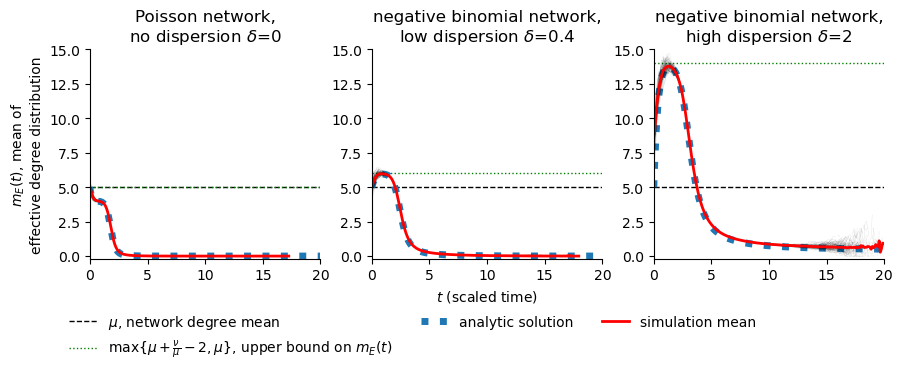

In [529]:
var = 'mE' # choose from list ['I','m','m2','v','mE','mE2','vE','mZ','mZ2','vZ']
fig, ax = plt.subplots(ncols=3)
fig.set_figheight(3.25)
fig.set_figwidth(9)

plot_var(var, 'no', ax[0])
plot_var(var, 'low', ax[1])
plot_var(var, 'high', ax[2])

ax[0].set_xlabel('')
ax[2].set_xlabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
plt.tight_layout()
plt.legend(bbox_to_anchor=(.7 if '2' in var else (0 if var=='I' else .5), -.2), frameon=False, ncol=3)

# plt.savefig('figures/'+var+'s.'+('svg' if var in ['m','mE'] else 'pdf'),bbox_inches='tight')

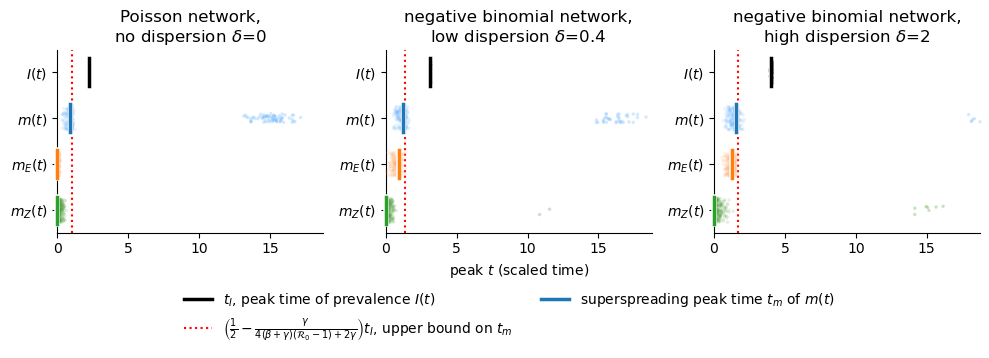

In [512]:
fig, ax = plt.subplots(ncols=3)
fig.set_figheight(3)
fig.set_figwidth(10)

plot_peak_ts('no',ax[0])
plot_peak_ts('low',ax[1])
plot_peak_ts('high',ax[2])

ax[0].set_xlabel('')
ax[2].set_xlabel('')

plt.tight_layout()

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           bbox_to_anchor=(.5, -.25), frameon=False, ncols=2)

# plt.savefig('figures/peak_ts.svg', bbox_inches='tight')

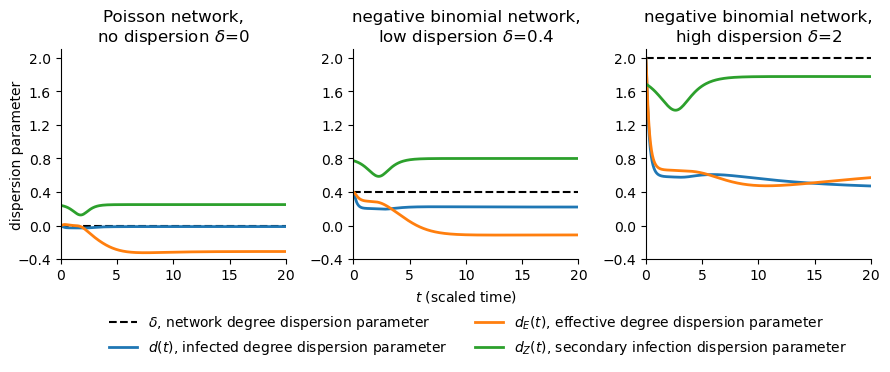

In [488]:
fig, ax = plt.subplots(ncols=3)
fig.set_figheight(3.25)
fig.set_figwidth(9)

plot_ds('no', ax[0])
plot_ds('low', ax[1])
plot_ds('high', ax[2])

ax[0].set_xlabel('')
ax[2].set_xlabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
plt.tight_layout()
plt.legend(bbox_to_anchor=(.95, -.2), frameon=False, ncol=2)

# plt.savefig('figures/ds.pdf',bbox_inches='tight')

In [438]:
initialize_high_dispersion()
peak_time = 1.5
inf_time = 10


init_I_Is = True
while init_I_Is:
    initial_infecteds = random.sample(range(n), init)

    stat = collections.defaultdict(lambda : 'S')
    for i in initial_infecteds:
        stat[i] = 'I'

    init_I_Is = False
    for i in initial_infecteds:
        if any(stat[j]=='I' for j in G.neighbors(i)):
            init_I_Is = True
            break

ts, S, I, R, m, m2, mE, mE2, new_infections, new_infection_times, num_transmissions, states, state_time_ixs = \
        Gillespie_SIR(G, beta, gamma, initial_infecteds = initial_infecteds, total_info_times = [peak_time, inf_time])

k_max = 50
ks = np.arange(0, k_max + 1)

dist_sim_zero = get_inf_deg_dist(states[0], k_max)
dist_sim_peak = get_inf_deg_dist(states[1], k_max)
dist_sim_inf = get_inf_deg_dist(states[2], k_max)

dist_ode_zero = scipy.stats.nbinom.pmf(ks, mu**2/(nu-mu), mu/nu)
y0 = np.concatenate(([theta0, i0], dist_ode_zero))

out_ode_pks_only = scipy.integrate.odeint(model_pks_only, y0, ts_ode)
dist_ode_peak = dist_ode_zero*ks / sum(dist_ode_zero*ks) #out_ode_pks_only[list(ts_ode).index(peak_time), 2:]
dist_ode_inf = np.concatenate(([0], scipy.stats.nbinom.pmf(ks[1:]-1, mu**2/(nu-mu) + 1,
                                                                     1 - out_ode_pks_only[-1,0] * (1 - mu/nu))))

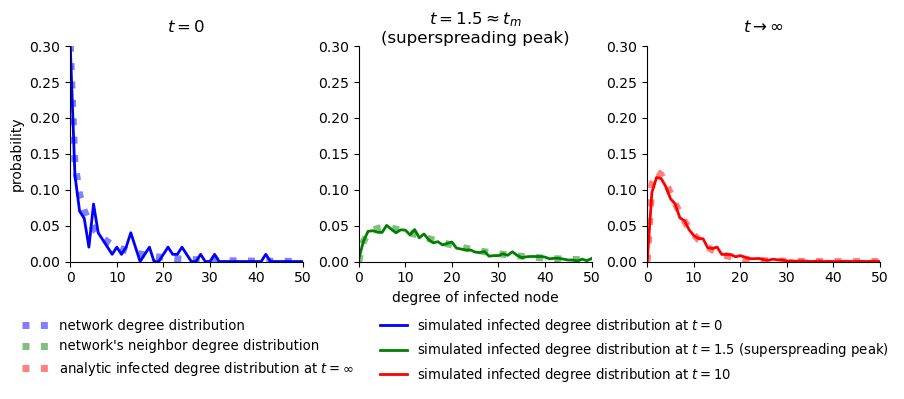

In [484]:
fig, ax = plt.subplots(ncols=3)
fig.set_figheight(3.25)
fig.set_figwidth(9)


ax[0].plot(ks, dist_ode_zero, color='blue', linestyle=':', linewidth=5, alpha=.5,
           label='network degree distribution')
ax[0].plot(ks, dist_sim_zero, color='blue', linewidth=2,
           label='simulated infected degree distribution at $t=0$')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_xlim(0,k_max)
ax[0].set_ylim(0,.3)
ax[0].set_ylabel('probability')
ax[0].set_title('$t=0$', pad=10)

ax[1].plot(ks, dist_ode_peak, color='green', linestyle=':', linewidth=5, alpha=.5,
           label='network\'s neighbor degree distribution')
ax[1].plot(ks, dist_sim_peak, color='green', linewidth=2,
           label='simulated infected degree distribution at $t=1.5$ (superspreading peak)')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlim(0,k_max)
ax[1].set_ylim(0,.3)
ax[1].set_xlabel('degree of infected node')
ax[1].set_title(r'$t=1.5\approx t_m$'+'\n(superspreading peak)', pad=-5)


ax[2].plot(ks, dist_ode_inf, color='red', linestyle=':', linewidth=5, alpha=.5,
           label='analytic infected degree distribution at $t=\infty$')
ax[2].plot(ks, dist_sim_inf, color='red', linewidth=2,
           label='simulated infected degree distribution at $t=10$')
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_xlim(0,k_max)
ax[2].set_ylim(0,.3)
ax[2].set_title(r'$t\rightarrow\infty$', pad=10)


plt.tight_layout()

handles0, labels0 = ax[0].get_legend_handles_labels()
handles1, labels1 = ax[1].get_legend_handles_labels()
handles2, labels2 = ax[2].get_legend_handles_labels()
handles = np.concatenate((handles0, handles1, handles2))
labels = np.concatenate((labels0, labels1, labels2))
order = [0,2,4,1,3,5]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           bbox_to_anchor=(1.09, -.2), frameon=False, ncol=2, prop={'size': 9.5})

# plt.savefig('figures/dists.pdf',bbox_inches='tight')

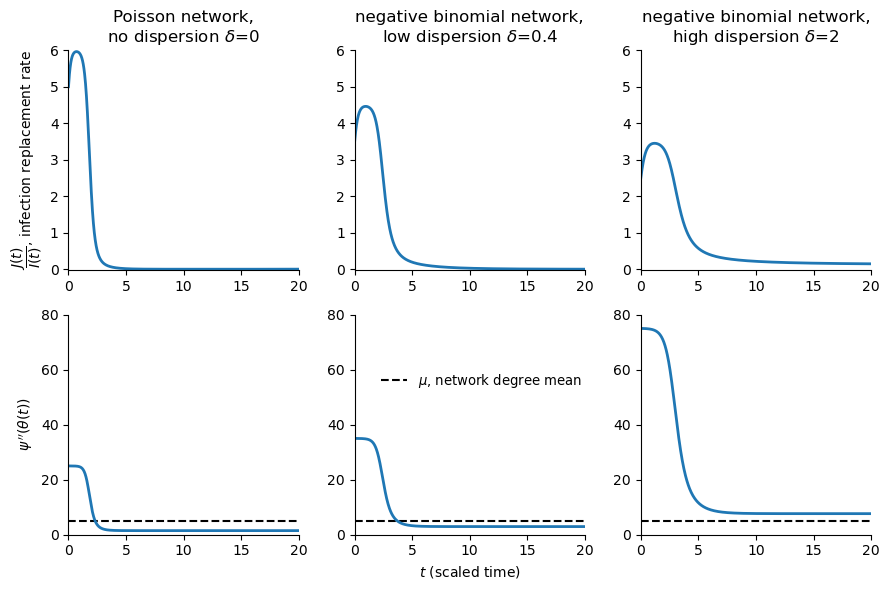

In [483]:
fig, ax = plt.subplots(nrows=2,ncols=3)
fig.set_figheight(6)
fig.set_figwidth(9)



initialize_no_dispersion()

out_ode_theta_I_only = scipy.integrate.odeint(model_theta_I_only, [theta0, i0], ts_ode)
theta = out_ode_theta_I_only[:,0]
dtheta = -beta * theta + beta * psi(theta)/psi(1) + gamma * (1-theta)
I = out_ode_theta_I_only[:,1]

ax[0,0].plot(ts_ode, -psi(theta)*dtheta/I, linewidth=2)
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].set_xlim(0,20)
ax[0,0].set_ylim(-.03,6)
ax[0,0].set_title('Poisson network,\nno dispersion '+r'$\delta$=0')
ax[0,0].set_ylabel(r'$\dfrac{J(t)}{I(t)}$, infection replacement rate')

ax[1,0].axhline(y=psi(1),color='black',linestyle='--')
ax[1,0].plot(ts_ode, psi2(theta), linewidth=2)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].set_xlim(0,20)
ax[1,0].set_ylim(0,80)
ax[1,0].set_ylabel('$\psi\,\'\'$'+r'$(\theta(t))$')



initialize_low_dispersion()

out_ode_theta_I_only = scipy.integrate.odeint(model_theta_I_only, [theta0, i0], ts_ode)
theta = out_ode_theta_I_only[:,0]
dtheta = -beta * theta + beta * psi(theta)/psi(1) + gamma * (1-theta)
I = out_ode_theta_I_only[:,1]

ax[0,1].plot(ts_ode, -psi(theta)*dtheta/I, linewidth=2)
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].set_xlim(0,20)
ax[0,1].set_ylim(-.03,6)
ax[0,1].set_title('negative binomial network,\nlow dispersion '+r'$\delta$=0.4')

ax[1,1].axhline(y=psi(1),color='black',linestyle='--',label='$\mu$, network degree mean')
ax[1,1].plot(ts_ode, psi2(theta), linewidth=2)
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].set_xlim(0,20)
ax[1,1].set_ylim(0,80)
ax[1,1].set_xlabel('$t$ (scaled time)')
ax[1,1].legend(frameon=False, fontsize=9.5, loc='center', bbox_to_anchor=(.55,.7))



initialize_high_dispersion()

out_ode_theta_I_only = scipy.integrate.odeint(model_theta_I_only, [theta0, i0], ts_ode)
theta = out_ode_theta_I_only[:,0]
dtheta = -beta * theta + beta * psi(theta)/psi(1) + gamma * (1-theta)
I = out_ode_theta_I_only[:,1]

ax[0,2].plot(ts_ode, -psi(theta)*dtheta/I, linewidth=2)
ax[0,2].spines['top'].set_visible(False)
ax[0,2].spines['right'].set_visible(False)
ax[0,2].set_xlim(0,20)
ax[0,2].set_ylim(-.03,6)
ax[0,2].set_title('negative binomial network,\nhigh dispersion '+r'$\delta$=2')

ax[1,2].axhline(y=psi(1),color='black',linestyle='--')
ax[1,2].plot(ts_ode, psi2(theta), linewidth=2)
ax[1,2].spines['top'].set_visible(False)
ax[1,2].spines['right'].set_visible(False)
ax[1,2].set_xlim(0,20)
ax[1,2].set_ylim(0,80)

plt.tight_layout()

# plt.savefig('figures/J_I.pdf',bbox_inches='tight')